In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, ConcatDataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available else "cpu"

In [ ]:
def driver_dataframe(df, path_order, driver):
    """
    Extracts and processes the DataFrame for a specific driver and path order.

    Parameters:
    df (DataFrame): The original DataFrame.
    path_order (int): The path order identifier.
    driver (str): The driver class identifier.

    Returns:
    DataFrame: Processed DataFrame for the specified driver and path order.
    """
    driver_df = df[df['PathOrder'] == path_order]
    driver_df = driver_df[driver_df['Class'] == driver]
    driver_df = driver_df.sort_values(by='Time(s)')
    driver_df.drop(columns=['Class', 'PathOrder'], inplace=True)
    driver_df = driver_df.groupby('Time(s)').mean()
    driver_df['Time(s)'] = driver_df.index
    return driver_df

In [ ]:
def split_dataset(df, train_ratio=0.8, random_seed=123):
    """
    Splits the dataset into training and testing sets based on driver and path order.

    Parameters:
    df (DataFrame): The original DataFrame.
    train_ratio (float): Ratio of the dataset to be used for training. Default is 0.8.
    random_seed (int): Seed for random number generator. Default is 123.

    Returns:
    DataFrame: Training set.
    DataFrame: Testing set.
    """

    # set a random seed
    np.random.seed(random_seed)

    # create a copy of dataframe
    df_copy = df.copy()

    # Lists to hold individual DataFrames
    df_train = []
    df_test = []

    # Nested loops to process each path and driver
    for path in df_copy['PathOrder'].unique():
        for driver in df_copy['Class'].unique():
            driver_df = driver_dataframe(df_copy, path, driver)
            driver_df['PathOrder'] = path  # Add PathOrder
            driver_df['Class'] = driver    # Add Class

            # Calculate the index to split the data
            split_index = int(train_ratio * len(driver_df))

            # Split the data
            df_train_split = driver_df.iloc[:split_index]
            df_test_split = driver_df.iloc[split_index:]

            # Append the data to df_train and df_test lists
            df_train.append(df_train_split)
            df_test.append(df_test_split)

    # Concatenate the DataFrames
    df_train = pd.concat(df_train, ignore_index=True)
    df_test = pd.concat(df_test, ignore_index=True)

    return df_train, df_test

In [ ]:
selected_features = ['Engine_soacking_time', 'Long_Term_Fuel_Trim_Bank1', 'Engine_coolant_temperature.1',
 'Torque_of_friction', 'Activation_of_Air_compressor', 'Intake_air_pressure', 'PathOrder', 'Accelerator_Pedal_value',
 'Master_cylinder_pressure', 'Vehicle_speed','Engine_coolant_temperature', 'Maximum_indicated_engine_torque',
 'Throttle_position_signal', 'Current_Gear', 'Calculated_LOAD_value', 'Engine_torque_after_correction',
 'Engine_torque', 'Class', 'Time(s)']

In [ ]:
data = pd.read_csv("/content/drive/My Drive/graduation/Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv")

In [ ]:
selected_df = data[selected_features]

In [ ]:
df_train, df_test = split_dataset(selected_df, 0.8)

In [ ]:

def driver_dataframe_using_window_size(df, path_order, driver, window_size=60):
    """
    Extracts and processes the DataFrame for a specific driver and path order,
    and calculates rolling statistics with the specified window size.

    Parameters:
    df (DataFrame): The original DataFrame.
    path_order (int): The path order identifier.
    driver (str): The driver class identifier.
    window_size (int): The size of the rolling window.

    Returns:
    DataFrame: Processed DataFrame for the specified driver and path order with
               rolling statistics concatenated to the original features.
    """

    # Filter the DataFrame for the specific driver and path order
    driver_df = df[df['PathOrder'] == path_order]
    driver_df = driver_df[driver_df['Class'] == driver]


    # Drop the 'Class' and 'PathOrder' columns
    time = driver_df['Time(s)']
    driver_df.drop(columns=['Class', 'PathOrder', 'Time(s)'], inplace=True)


    # Calculate rolling statistics
    rolling_mean = driver_df.rolling(window=window_size).mean().add_suffix('_mean')
    rolling_median = driver_df.rolling(window=window_size).median().add_suffix('_median')
    rolling_std = driver_df.rolling(window=window_size).std().add_suffix('_std')
#     rolling_var = driver_df.rolling(window=window_size).var().add_suffix('_var')
#     rolling_min = driver_df.rolling(window=window_size).min().add_suffix('_min')
#     rolling_max = driver_df.rolling(window=window_size).max().add_suffix('_max')

    # Concatenate the original features with the rolling statistics
    # , rolling_var, rolling_min, rolling_max
    driver_df = pd.concat([driver_df, rolling_mean, rolling_median, rolling_std], axis=1)
    driver_df['Time(s)'] = time
    # Drop the first 'window_size' rows to make the concatenation match
    driver_df = driver_df.iloc[window_size-1:]

    return driver_df


In [ ]:
def prepare_all_drivers(df, random_seed=123):
    """
    Prepares the dataset by processing each driver's data and calculating rolling statistics for each feature.

    Parameters:
    df (DataFrame): The original DataFrame.
    random_seed (int): The seed for the random number generator (default is 123).

    Returns:
    DataFrame: Processed DataFrame with rolling statistics and necessary columns for all drivers.
    """

    # Set the random seed for reproducibility
    np.random.seed(random_seed)

    # Create a copy of the original DataFrame to ensure the original data is not altered
    df_copy = df.copy()

    # List to hold individual DataFrames for each driver and path
    df_temp = []

    # Nested loops to process each path and driver
    for path in df_copy['PathOrder'].unique():
        for driver in df_copy['Class'].unique():
            # Process the DataFrame for the specific driver and path using window size
            driver_df = driver_dataframe_using_window_size(df_copy, path, driver)
            driver_df['PathOrder'] = path  # Add PathOrder column
            driver_df['Class'] = driver    # Add Class column

            # Append the processed DataFrame to the list
            df_temp.append(driver_df)

    # Concatenate all individual DataFrames into a single DataFrame
    all_drivers = pd.concat(df_temp, ignore_index=True)

    return all_drivers

In [ ]:
train_data = prepare_all_drivers(df_train)
test_data = prepare_all_drivers(df_test)

<ipython-input-11-e749b40c2d26>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_df['PathOrder'] = path  # Add PathOrder column
<ipython-input-11-e749b40c2d26>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_df['Class'] = driver    # Add Class column


### Data Preprocessing

In [ ]:
deriver_d_path1 = train_data[(train_data['Class']=="D") & (train_data['PathOrder']==1) ]
deriver_d_path2 = train_data[(train_data['Class']=="D") & (train_data['PathOrder']==2) ]

In [ ]:
deriver_d_path1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
deriver_d_path2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)

<ipython-input-14-d748fa936b9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deriver_d_path1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-14-d748fa936b9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deriver_d_path2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


In [ ]:
one_deriver_data_path1 = deriver_d_path1.values
one_deriver_data_path2 = deriver_d_path2.values

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = np.array(data,dtype=float)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        return self.data[idx:idx+self.sequence_length]

In [ ]:
sequence_length = 60
dataset_path1 = TimeSeriesDataset(one_deriver_data_path1, sequence_length)
dataset_path2 = TimeSeriesDataset(one_deriver_data_path2, sequence_length)
concatenated_data = ConcatDataset([dataset_path1, dataset_path2])
dataloader = DataLoader(concatenated_data, batch_size=32, shuffle=True)


### Modeling

In [ ]:
class ComplexTimeSeriesAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, sequence_lengt):
        super(ComplexTimeSeriesAutoencoder, self).__init__()

        # Define the CNN Encoder
        self.cnn_encoder = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Define the LSTM Encoder
        self.lstm_encoder = nn.LSTM(input_size=64, hidden_size=latent_dim, batch_first=True)

        # Define the LSTM Decoder
        self.lstm_decoder = nn.LSTM(input_size=latent_dim, hidden_size=64, batch_first=True)

        # Define the CNN Decoder
        self.cnn_decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=input_dim, kernel_size=3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        # Pass the input through the CNN Encoder
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, input_dim, sequence_length) for CNN
        x = self.cnn_encoder(x)
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, sequence_length, num_channels) for LSTM

        # Pass through the LSTM Encoder
        x, _ = self.lstm_encoder(x)

        # Pass through the LSTM Decoder
        x, _ = self.lstm_decoder(x)

        # Pass through the CNN Decoder
        x = x.permute(0, 2, 1)  # Change shape to (batch_size, num_channels, sequence_length) for CNN
        x = self.cnn_decoder(x)
        x = x.permute(0, 2, 1)  # Change shape back to (batch_size, sequence_length, input_dim)

        return x

In [ ]:
one_deriver_data_path1.shape

(1726, 64)

In [ ]:
input_dim = one_deriver_data_path1.shape[1]
latent_dim = 20
model = ComplexTimeSeriesAutoencoder(input_dim, latent_dim, sequence_length).to(device)

In [ ]:
num_epochs = 100
learning_rate = 0.001
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:


# for epoch in range(num_epochs):
#     for batch in dataloader:
#         batch = batch.float().to(device)
#         outputs = model(batch)
#         loss = criterion(outputs, batch)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 5.3163
Epoch [2/20], Loss: 7.7159
Epoch [3/20], Loss: 6.0024
Epoch [4/20], Loss: 7.2494
Epoch [5/20], Loss: 6.4511
Epoch [6/20], Loss: 6.7225
Epoch [7/20], Loss: 4.8788
Epoch [8/20], Loss: 5.5105
Epoch [9/20], Loss: 5.5099
Epoch [10/20], Loss: 4.9683
Epoch [11/20], Loss: 5.9810
Epoch [12/20], Loss: 5.1820
Epoch [13/20], Loss: 6.6218
Epoch [14/20], Loss: 5.0998
Epoch [15/20], Loss: 6.5156
Epoch [16/20], Loss: 7.2608
Epoch [17/20], Loss: 4.8451
Epoch [18/20], Loss: 5.7954
Epoch [19/20], Loss: 7.2420
Epoch [20/20], Loss: 5.9700


In [ ]:
# Load the saved model state dict
model.load_state_dict(torch.load('complex_time_series_autoencoder.pth', map_location=device))

<All keys matched successfully>

In [ ]:
dataset_path1 = TimeSeriesDataset(one_deriver_data_path1, sequence_length)
dataset_path2 = TimeSeriesDataset(one_deriver_data_path2, sequence_length)
concatenated_data = ConcatDataset([dataset_path1, dataset_path2])
train_dataloader = DataLoader(concatenated_data, batch_size=1, shuffle=True)

In [ ]:
def calculate_reconstruction_error(model, dataloader):
    model.eval()
    errors = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.float().to(device)
            outputs = model(batch)
            loss = criterion(outputs, batch)
            errors.append(loss.item())
    return errors

validation_errors = calculate_reconstruction_error(model, train_dataloader)
# threshold = np.mean(validation_errors) + 3 * np.std(validation_errors)
# print(f'Reconstruction error threshold: {threshold:.4f}')

In [ ]:
np.array(validation_errors).shape

(3652,)

In [ ]:
threshold = np.quantile(np.array(validation_errors), 0.95)
threshold

5.102414464950561

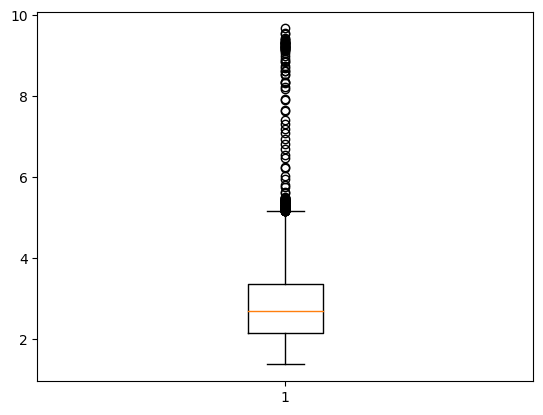

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot(validation_errors)
plt.show()

### Evaluate the model

In [ ]:
test_data_one_deriver_2 = test_data[(test_data['Class']=="D") & (test_data['PathOrder']==2) ]
test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
test_data_one_deriver_1 = test_data[(test_data['Class']=="D") & (test_data['PathOrder']==1) ]
test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)

test_dataset_path2 = TimeSeriesDataset(test_data_one_deriver_2.values, sequence_length)
test_dataset_path1 = TimeSeriesDataset(test_data_one_deriver_1.values, sequence_length)
concatenated_data = ConcatDataset([test_dataset_path1, test_dataset_path2])
test_dataloader = DataLoader(concatenated_data, batch_size=1, shuffle=True)


<ipython-input-78-342d8dddc8a3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-78-342d8dddc8a3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


In [ ]:
anomalies = []
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.float().to(device)
        outputs = model(batch)
        loss = criterion(outputs, batch)
        # print(loss)
        if loss.item() > threshold:
            anomalies.append(True)
        else:
            anomalies.append(False)

In [ ]:
anomalies

[True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 

In [ ]:
true_count = 0
for res in anomalies:
    if res:
        true_count += 1
print(f"acc: {true_count/len(anomalies)}")

acc: 0.6779891304347826


### Evalute on another driver

In [ ]:
driver_cls = "A"
test_data_one_deriver_1 = train_data[(train_data['Class']==driver_cls) & (train_data['PathOrder']==1) ]
test_data_one_deriver_2 = train_data[(train_data['Class']==driver_cls) & (train_data['PathOrder']==2) ]
test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
test_dataset_path2 = TimeSeriesDataset(test_data_one_deriver_2.values, sequence_length)
test_dataset_path1 = TimeSeriesDataset(test_data_one_deriver_1.values, sequence_length)
concatenated_data = ConcatDataset([test_dataset_path1, test_dataset_path2])
test_dataloader = DataLoader(concatenated_data, batch_size=1, shuffle=True)


<ipython-input-69-0d3585964391>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-69-0d3585964391>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


In [ ]:
anomalies = []
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.float().to(device)
        outputs = model(batch)
        loss = criterion(outputs, batch)
        # print(loss)
        if loss.item() > threshold:
            anomalies.append(True)
        else:
            anomalies.append(False)

In [ ]:
anomalies

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [ ]:
def evalute_per_class():
    deriver_classes = train_data['Class'].unique()
    for deriver_cls in deriver_classes:
        test_data_one_deriver_1 = train_data[(train_data['Class']==deriver_cls) & (train_data['PathOrder']==1) ]
        test_data_one_deriver_2 = train_data[(train_data['Class']==deriver_cls) & (train_data['PathOrder']==2) ]
        test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
        test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
        test_dataset_path2 = TimeSeriesDataset(test_data_one_deriver_2.values, sequence_length)
        test_dataset_path1 = TimeSeriesDataset(test_data_one_deriver_1.values, sequence_length)
        concatenated_data = ConcatDataset([test_dataset_path1, test_dataset_path2])
        test_dataloader = DataLoader(concatenated_data, batch_size=1, shuffle=True)
        anomalies_cnt = 0
        with torch.no_grad():
            for batch in test_dataloader:
                batch = batch.float().to(device)
                outputs = model(batch)
                loss = criterion(outputs, batch)
                if loss.item() > threshold:
                    anomalies_cnt += 1
        print(f"class {deriver_cls}  acc: {anomalies_cnt/(len(test_data_one_deriver_1)+len(test_data_one_deriver_2))}")


In [ ]:
evalute_per_class()

<ipython-input-72-0790670f5628>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-72-0790670f5628>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class A  acc: 0.9575671852899575


<ipython-input-72-0790670f5628>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-72-0790670f5628>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class D  acc: 0.04851537645811241


<ipython-input-72-0790670f5628>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-72-0790670f5628>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class B  acc: 0.8420470262793914


<ipython-input-72-0790670f5628>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-72-0790670f5628>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class C  acc: 0.858732299393122


<ipython-input-72-0790670f5628>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-72-0790670f5628>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class I  acc: 0.9637352674524026


<ipython-input-72-0790670f5628>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-72-0790670f5628>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class J  acc: 0.9698037242073477


<ipython-input-72-0790670f5628>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-72-0790670f5628>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class H  acc: 0.9713945172824792


<ipython-input-72-0790670f5628>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-72-0790670f5628>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class G  acc: 0.9592668024439919


<ipython-input-72-0790670f5628>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-72-0790670f5628>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class F  acc: 0.9576308784383318


<ipython-input-72-0790670f5628>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-72-0790670f5628>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class E  acc: 0.9681359532660648


In [ ]:
def evalute_per_class():
    deriver_classes = train_data['Class'].unique()
    for deriver_cls in deriver_classes:
        test_data_one_deriver_1 = test_data[(test_data['Class']==deriver_cls) & (test_data['PathOrder']==1) ]
        test_data_one_deriver_2 = test_data[(test_data['Class']==deriver_cls) & (test_data['PathOrder']==2) ]
        test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
        test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
        test_dataset_path2 = TimeSeriesDataset(test_data_one_deriver_2.values, sequence_length)
        test_dataset_path1 = TimeSeriesDataset(test_data_one_deriver_1.values, sequence_length)
        concatenated_data = ConcatDataset([test_dataset_path1, test_dataset_path2])
        test_dataloader = DataLoader(concatenated_data, batch_size=1, shuffle=True)
        anomalies_cnt = 0
        with torch.no_grad():
            for batch in test_dataloader:
                batch = batch.float().to(device)
                outputs = model(batch)
                loss = criterion(outputs, batch)
                if loss.item() > threshold:
                    anomalies_cnt += 1
        print(f"class {deriver_cls}  acc: {anomalies_cnt/(len(test_data_one_deriver_1)+len(test_data_one_deriver_2))}")


In [ ]:
evalute_per_class()

<ipython-input-76-46908777ce54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-76-46908777ce54>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class A  acc: 0.8064516129032258


<ipython-input-76-46908777ce54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-76-46908777ce54>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class D  acc: 0.5829439252336449


<ipython-input-76-46908777ce54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-76-46908777ce54>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class B  acc: 0.6597307221542228


<ipython-input-76-46908777ce54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-76-46908777ce54>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class C  acc: 0.7966360856269113


<ipython-input-76-46908777ce54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-76-46908777ce54>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class I  acc: 0.8376184032476319


<ipython-input-76-46908777ce54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-76-46908777ce54>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class J  acc: 0.8675496688741722


<ipython-input-76-46908777ce54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-76-46908777ce54>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class H  acc: 0.8751300728407908


<ipython-input-76-46908777ce54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-76-46908777ce54>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class G  acc: 0.8153846153846154


<ipython-input-76-46908777ce54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-76-46908777ce54>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class F  acc: 0.8846153846153846


<ipython-input-76-46908777ce54>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_1.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)
<ipython-input-76-46908777ce54>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_one_deriver_2.drop(columns=['Time(s)', 'PathOrder', 'Class'], inplace=True)


class E  acc: 0.8594847775175644
